In [10]:
# Homework 2
# Group 18

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image, ImageEnhance, ImageFilter
import random

In [12]:
# Set Constants
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

LATENT_DIM = 256
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
DROPOUT_RATE = 0
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Loading Data
keywords = ['face']
dataset = load_dataset('valhalla/emoji-dataset')['train']
imgs = []
for data in dataset:
    title = data['text'].lower()
    if any (k in title for k in keywords):
        img = data['image'].convert('RGB').resize((64, 64), Image.LANCZOS)
        imgs.append(img)
X = np.stack(imgs)
print(X.shape)

(204, 64, 64, 3)


In [14]:
# Data augmentation
original_size = len(imgs)
train_size_target = 600
val_size_target = 200
test_size_target = 200
total_target = train_size_target + val_size_target + test_size_target

indices = np.arange(len(imgs))
np.random.shuffle(indices)
train_size = int(0.6 * original_size)
val_size = int(0.2 * original_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]
train_imgs_orig = [imgs[i] for i in train_indices]
val_imgs_orig = [imgs[i] for i in val_indices]
test_imgs_orig = [imgs[i] for i in test_indices]

def augment_image(img):
    augmented = []
    augmented.append(img)
    augmented.append(img.rotate(30, fillcolor=(255, 255, 255)))
    augmented.append(img.rotate(-30, fillcolor=(255, 255, 255)))
    augmented.append(ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2)))
    augmented.append(ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2)))
    return augmented

def augment_dataset(imgs, target_size):
    augmented = []
    imgs_shuffled = imgs.copy()
    random.shuffle(imgs_shuffled)
    while(len(augmented)) < target_size:
        for img in imgs_shuffled:
            if len(augmented) >= target_size:
                break
            aug_imgs = augment_image(img)
            augmented.extend(aug_imgs)
    return augmented

train_imgs = augment_dataset(train_imgs_orig, train_size_target)
val_imgs = augment_dataset(val_imgs_orig, val_size_target)
test_imgs = augment_dataset(test_imgs_orig, test_size_target)
random.shuffle(train_imgs)
random.shuffle(val_imgs)
random.shuffle(test_imgs)

transform = T.Compose([
    T.ToTensor(),
])
X_train = torch.stack([transform(img) for img in train_imgs])
X_val = torch.stack([transform(img) for img in val_imgs])
X_test = torch.stack([transform(img) for img in test_imgs])
train_dataset = TensorDataset(X_train, X_train)
val_dataset = TensorDataset(X_val, X_val)
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [15]:
# define model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim = LATENT_DIM):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),


            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),
        )

        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(256 * 4 * 4, self.latent_dim)
        self.fc_decode = nn.Linear(self.latent_dim, 256 * 4 * 4)
        self.unflatten = nn.Unflatten(1, (256, 4, 4))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_encode(x)
        return z
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

In [16]:
# Train the model
model = ConvAutoencoder(latent_dim = LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = 1e-5)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch + 1}/{NUM_EPOCHS}")):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon, _ = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(DEVICE)
            recon, _ = model(data)
            loss = criterion(recon, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Train Loss : {train_loss:.6f}, Val Loss : {val_loss:.6f}")

model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        recon, _ = model(data)
        loss = criterion(recon, data)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

Epoch 1/30: 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


Train Loss : 0.113756, Val Loss : 0.104210


Epoch 2/30: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Train Loss : 0.064679, Val Loss : 0.055829


Epoch 3/30: 100%|██████████| 19/19 [00:02<00:00,  8.97it/s]


Train Loss : 0.045221, Val Loss : 0.038529


Epoch 4/30: 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]


Train Loss : 0.035223, Val Loss : 0.031055


Epoch 5/30: 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]


Train Loss : 0.029156, Val Loss : 0.027280


Epoch 6/30: 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


Train Loss : 0.025634, Val Loss : 0.025253


Epoch 7/30: 100%|██████████| 19/19 [00:01<00:00,  9.62it/s]


Train Loss : 0.023038, Val Loss : 0.024018


Epoch 8/30: 100%|██████████| 19/19 [00:01<00:00,  9.65it/s]


Train Loss : 0.020629, Val Loss : 0.022155


Epoch 9/30: 100%|██████████| 19/19 [00:01<00:00,  9.67it/s]


Train Loss : 0.018727, Val Loss : 0.021916


Epoch 10/30: 100%|██████████| 19/19 [00:01<00:00,  9.84it/s]


Train Loss : 0.018044, Val Loss : 0.022646


Epoch 11/30: 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


Train Loss : 0.017321, Val Loss : 0.020093


Epoch 12/30: 100%|██████████| 19/19 [00:02<00:00,  8.95it/s]


Train Loss : 0.015952, Val Loss : 0.019430


Epoch 13/30: 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]


Train Loss : 0.014745, Val Loss : 0.021041


Epoch 14/30: 100%|██████████| 19/19 [00:02<00:00,  9.03it/s]


Train Loss : 0.013888, Val Loss : 0.018990


Epoch 15/30: 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Train Loss : 0.013244, Val Loss : 0.018914


Epoch 16/30: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Train Loss : 0.012929, Val Loss : 0.018759


Epoch 17/30: 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


Train Loss : 0.012144, Val Loss : 0.017916


Epoch 18/30: 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


Train Loss : 0.011851, Val Loss : 0.017506


Epoch 19/30: 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]


Train Loss : 0.011309, Val Loss : 0.017787


Epoch 20/30: 100%|██████████| 19/19 [00:02<00:00,  8.52it/s]


Train Loss : 0.010557, Val Loss : 0.017811


Epoch 21/30: 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


Train Loss : 0.010146, Val Loss : 0.016969


Epoch 22/30: 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


Train Loss : 0.009829, Val Loss : 0.017514


Epoch 23/30: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Train Loss : 0.009194, Val Loss : 0.016811


Epoch 24/30: 100%|██████████| 19/19 [00:01<00:00,  9.55it/s]


Train Loss : 0.009012, Val Loss : 0.017283


Epoch 25/30: 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


Train Loss : 0.008493, Val Loss : 0.016978


Epoch 26/30: 100%|██████████| 19/19 [00:01<00:00,  9.54it/s]


Train Loss : 0.008315, Val Loss : 0.016938


Epoch 27/30: 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


Train Loss : 0.007854, Val Loss : 0.017418


Epoch 28/30: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Train Loss : 0.007985, Val Loss : 0.016587


Epoch 29/30: 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


Train Loss : 0.007536, Val Loss : 0.016518


Epoch 30/30: 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


Train Loss : 0.007869, Val Loss : 0.016462
Test Loss: 0.017636


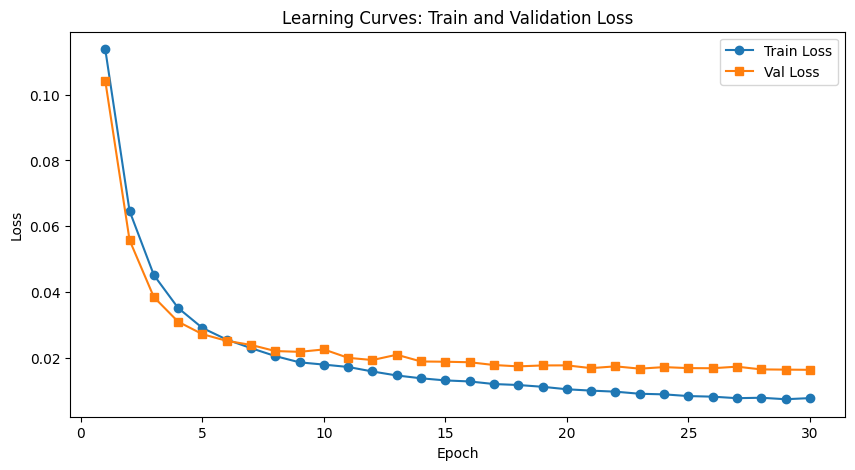

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = 'Train Loss', marker = 'o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label = 'Val Loss', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Learning Curves: Train and Validation Loss")
plt.savefig('q1_learning_curves.png', dpi = 300, bbox_inches = 'tight')
plt.show()

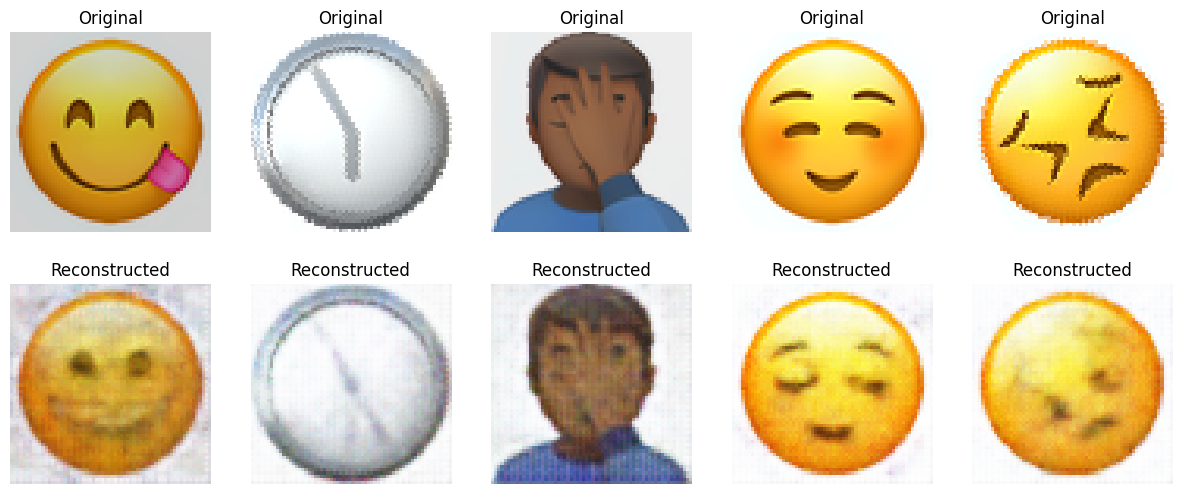

In [ ]:
model.eval()
with torch.no_grad():
    sample_data = X_test[:5].to(DEVICE)
    recon_data, _ = model(sample_data)
    sample_data = sample_data.cpu().numpy()
    recon_data = recon_data.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize = (15, 6))
    for i in range(5):
        axes[0, i].imshow(np.transpose(sample_data[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].imshow(np.transpose(recon_data[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    plt.savefig('q1_reconstructions.png', dpi = 300, bbox_inches = 'tight')
    plt.show()